# Hands-On Pertemuan 9: Spark SQL

## Tujuan:
- Mengasah keterampilan analisis data menggunakan Spark SQL.
- Melakukan lebih banyak latihan SQL yang mengarah ke skenario dunia nyata.
- Mempersiapkan mahasiswa untuk menggunakan Spark SQL dalam proyek besar.


### 1. Refresher: Basic SQL Operations in Spark SQL
- **Tugas 1**: Ulangi pemahaman Anda tentang SQL dasar dengan menjalankan queries sederhana pada dataset di Spark SQL.


In [5]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('HandsOnPertemuan9').getOrCreate()
data = [
    ('Musa', 22, 'Laki-laki', 3000, 1),
    ('Tika', 19, 'Perempuan', 4100, 2),
    ('Jaka', 23, 'Laki-laki', 2700, 1),
    ('Dita', 22, 'Perempuan', 3500, 1),
    ('Arya', 23, 'Laki-laki', 3200, 2)
]
columns = ['Name', 'Age', 'Gender', 'Salary', 'DeptId']
df = spark.createDataFrame(data, schema=columns)
df.createOrReplaceTempView('employees')
spark.sql('SELECT * FROM employees').show()
spark.sql('SELECT Name, Age FROM employees WHERE Salary > 3000').show()
spark.sql('SELECT AVG(Salary) FROM employees').show()

+----+---+---------+------+------+
|Name|Age|   Gender|Salary|DeptId|
+----+---+---------+------+------+
|Musa| 22|Laki-laki|  3000|     1|
|Tika| 19|Perempuan|  4100|     2|
|Jaka| 23|Laki-laki|  2700|     1|
|Dita| 22|Perempuan|  3500|     1|
|Arya| 23|Laki-laki|  3200|     2|
+----+---+---------+------+------+

+----+---+
|Name|Age|
+----+---+
|Tika| 19|
|Dita| 22|
|Arya| 23|
+----+---+

+-----------+
|avg(Salary)|
+-----------+
|     3300.0|
+-----------+



### 2. Advanced Queries for Data Analysis
Gunakan queries lebih kompleks, melibatkan grouping, filtering, dan subqueries.
- **Tugas 2**: Buat SQL query yang menghitung total gaji berdasarkan jenis kelamin dan usia.


In [6]:
spark.sql('''
SELECT Gender, SUM(Salary) as TotalSalary, Age
FROM employees
GROUP BY Gender, Age
ORDER BY Age
''').show()

#1 Rata-rata gaji per departemen
spark.sql('''
SELECT DeptId, AVG(Salary) AS AverageSalary
FROM employees
GROUP BY DeptId
''').show()
#2 Karyawan yang memiliki gaji di atas rata-rata untuk gender masing-masing
spark.sql('''
WITH avg_salary_by_gender AS (
    SELECT Gender, AVG(Salary) AS AverageSalary
    FROM employees
    GROUP BY Gender
)
SELECT e.Name, e.Gender, e.Salary, g.AverageSalary
FROM employees e
JOIN avg_salary_by_gender g
    ON e.Gender = g.Gender
WHERE e.Salary > g.AverageSalary
''').show()
#3 Rangking karyawan berdasarkan gaji dalam departemen
spark.sql('''
SELECT Name, DeptId, Salary,
       DENSE_RANK() OVER (PARTITION BY DeptId ORDER BY Salary DESC) AS Rank
FROM employees
''').show()

+---------+-----------+---+
|   Gender|TotalSalary|Age|
+---------+-----------+---+
|Perempuan|       4100| 19|
|Laki-laki|       3000| 22|
|Perempuan|       3500| 22|
|Laki-laki|       5900| 23|
+---------+-----------+---+

+------+------------------+
|DeptId|     AverageSalary|
+------+------------------+
|     1|3066.6666666666665|
|     2|            3650.0|
+------+------------------+

+----+---------+------+------------------+
|Name|   Gender|Salary|     AverageSalary|
+----+---------+------+------------------+
|Musa|Laki-laki|  3000|2966.6666666666665|
|Tika|Perempuan|  4100|            3800.0|
|Arya|Laki-laki|  3200|2966.6666666666665|
+----+---------+------+------------------+

+----+------+------+----+
|Name|DeptId|Salary|Rank|
+----+------+------+----+
|Dita|     1|  3500|   1|
|Musa|     1|  3000|   2|
|Jaka|     1|  2700|   3|
|Tika|     2|  4100|   1|
|Arya|     2|  3200|   2|
+----+------+------+----+



### 3. Penggunaan Window Functions dan Subqueries
Latihan penggunaan window functions untuk menemukan karyawan dengan gaji tertinggi dan urutannya berdasarkan kelompok usia.
- **Tugas 3**: Terapkan window functions untuk menemukan top 3 karyawan dalam kelompok usia tertentu.


In [7]:
spark.sql('''
SELECT Name, Age, Salary, ROW_NUMBER() OVER (PARTITION BY Age ORDER BY Salary DESC) as rank
FROM employees
''').show()

from pyspark.sql import functions as F  
from pyspark.sql.window import Window 
 
windowSpec = Window.partitionBy('Age').orderBy(F.desc('Salary'))   
ranked_df = df.withColumn('rank', F.row_number().over(windowSpec))  
top_3_employees = ranked_df.filter(ranked_df.rank <= 3)  
top_3_employees.show() 

+----+---+------+----+
|Name|Age|Salary|rank|
+----+---+------+----+
|Tika| 19|  4100|   1|
|Dita| 22|  3500|   1|
|Musa| 22|  3000|   2|
|Arya| 23|  3200|   1|
|Jaka| 23|  2700|   2|
+----+---+------+----+

+----+---+---------+------+------+----+
|Name|Age|   Gender|Salary|DeptId|rank|
+----+---+---------+------+------+----+
|Tika| 19|Perempuan|  4100|     2|   1|
|Dita| 22|Perempuan|  3500|     1|   1|
|Musa| 22|Laki-laki|  3000|     1|   2|
|Arya| 23|Laki-laki|  3200|     2|   1|
|Jaka| 23|Laki-laki|  2700|     1|   2|
+----+---+---------+------+------+----+



### 4. Advanced Spark SQL Queries
Menjelajahi queries yang lebih kompleks yang melibatkan multiple joins, subqueries, dan window functions.
- **Tugas 4**: Demonstrasi penggunaan multi-level joins dan subqueries untuk analisis data yang mendalam.


In [8]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Pertemuan9').getOrCreate()

# Data setup for complex SQL queries
employees = spark.createDataFrame([
    ('Musa', 22, 'Laki-laki', 3000, 1),
    ('Tika', 19, 'Perempuan', 4100, 2),
    ('Jaka', 23, 'Laki-laki', 2700, 1),
    ('Dita', 22, 'Perempuan', 3500, 1),
    ('Arya', 23, 'Laki-laki', 3200, 2),
], ['Name', 'Age', 'Gender', 'Salary', 'DeptId'])
departments = spark.createDataFrame([
    (1, 'HR'),
    (2, 'Marketing')
], ['DeptId', 'DeptName'])
projects = spark.createDataFrame([
    (1, 'Project A'),
    (2, 'Project B')
], ['DeptId', 'ProjectName'])
employees.createOrReplaceTempView('employees')
departments.createOrReplaceTempView('departments')
projects.createOrReplaceTempView('projects')

# Complex SQL query involving multiple joins and subqueries
spark.sql('''
SELECT e.Name, e.Age, d.DeptName, p.ProjectName
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
JOIN projects p ON e.DeptId = p.DeptId
''').show()

#query SQL untuk menemukan rata-rata gaji per departemen dan rangking setiap karyawan dalam departemen berdasarkan gaji
spark.sql('''
SELECT Name, Age, Salary, DeptID,
       AVG(Salary) OVER (PARTITION BY DeptID) as AvgSalary,
       RANK() OVER (PARTITION BY DeptID ORDER BY Salary DESC) as SalaryRank
FROM employees
''').show()

#menentukan tren gaji berdasarkan usia di setiap departemen dengan mengunakan window functions
windowSpec = Window.partitionBy('DeptId', 'Age').orderBy('Salary')  
salary_trend_df = employees.groupBy('DeptId', 'Age').agg(F.avg('Salary').alias('AvgSalary'))   
ranked_trend_df = salary_trend_df.withColumn('rank', F.row_number().over(Window.partitionBy('DeptId').orderBy('AvgSalary')))  
ranked_trend_df.show()  

+----+---+---------+-----------+
|Name|Age| DeptName|ProjectName|
+----+---+---------+-----------+
|Dita| 22|       HR|  Project A|
|Jaka| 23|       HR|  Project A|
|Musa| 22|       HR|  Project A|
|Arya| 23|Marketing|  Project B|
|Tika| 19|Marketing|  Project B|
+----+---+---------+-----------+

+----+---+------+------+------------------+----------+
|Name|Age|Salary|DeptID|         AvgSalary|SalaryRank|
+----+---+------+------+------------------+----------+
|Dita| 22|  3500|     1|3066.6666666666665|         1|
|Musa| 22|  3000|     1|3066.6666666666665|         2|
|Jaka| 23|  2700|     1|3066.6666666666665|         3|
|Tika| 19|  4100|     2|            3650.0|         1|
|Arya| 23|  3200|     2|            3650.0|         2|
+----+---+------+------+------------------+----------+

+------+---+---------+----+
|DeptId|Age|AvgSalary|rank|
+------+---+---------+----+
|     1| 23|   2700.0|   1|
|     1| 22|   3250.0|   2|
|     2| 23|   3200.0|   1|
|     2| 19|   4100.0|   2|
+------+--

### 5. Advanced Data Analysis and Visualization
Penerapan teknik analisis data yang lebih canggih dan visualisasi menggunakan PySpark dan matplotlib.
- **Tugas 7**: Lakukan analisis tren gaji menggunakan Spark SQL dan visualisasikan hasilnya.


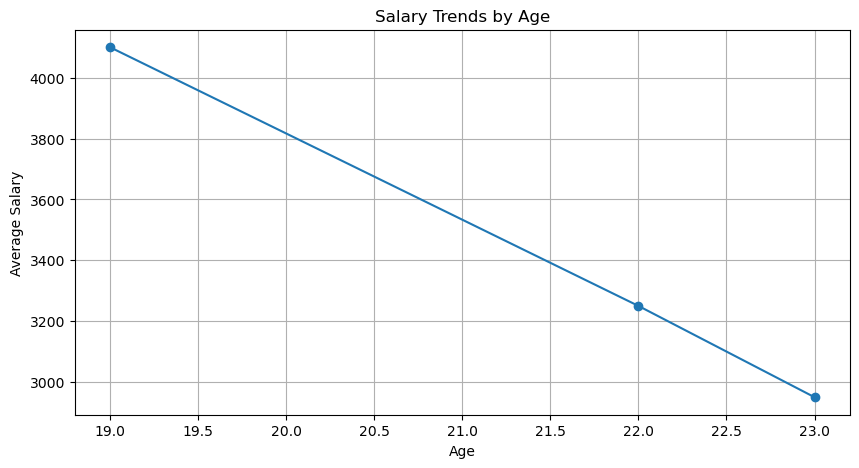

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Advanced data analysis with visualization
salary_trends = spark.sql('''
SELECT Age, AVG(Salary) AS AverageSalary
FROM employees
GROUP BY Age
ORDER BY Age
''').toPandas()

# Visualization of salary trends
plt.figure(figsize=(10, 5))
plt.plot(salary_trends['Age'], salary_trends['AverageSalary'], marker='o')
plt.xlabel('Age')
plt.ylabel('Average Salary')
plt.title('Salary Trends by Age')
plt.grid(True)
plt.show()


### 6. Homework
- **Tugas 1**: Gunakan Spark SQL untuk mencari total gaji dan jumlah karyawan per departemen. Buat visualisasi perbandingan antar departemen.
- **Tugas 2**: Temukan karyawan dengan gaji di atas rata-rata dalam setiap kelompok usia dan visualisasikan data ini dalam bentuk grafik batang atau pie chart.
- **Tugas 3**: Buat dataset yang lebih besar (misalnya, 100+ baris) dan lakukan analisis mendalam menggunakan SQL functions seperti `SUM()`, `AVG()`, `COUNT()`, serta `JOIN` antar tabel serta buat visualisasi yang menarik.


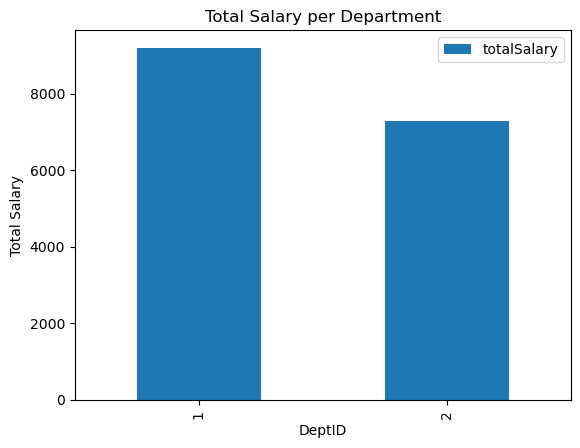

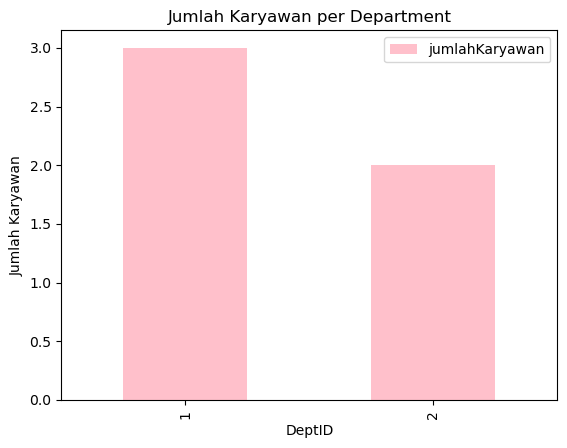

In [10]:
#Mencari total gaji dan jumlah karyawan per departemen dengan menggunakan Spark SQL
totalsalary_trends = spark.sql('''
SELECT DeptID, SUM(Salary) as totalSalary
FROM employees
GROUP BY DeptID
''').toPandas()

jmlhkaryawan_trends = spark.sql('''
SELECT DeptID, COUNT(*) as jumlahKaryawan
FROM employees
GROUP BY DeptID
''').toPandas()

totalsalary_trends.plot(x='DeptID', y='totalSalary', kind='bar')
plt.xlabel('DeptID')
plt.ylabel('Total Salary')
plt.title('Total Salary per Department')

jmlhkaryawan_trends.plot(x='DeptID', y='jumlahKaryawan', kind='bar', color='pink')
plt.xlabel('DeptID')
plt.ylabel('Jumlah Karyawan')
plt.title('Jumlah Karyawan per Department')
plt.show()

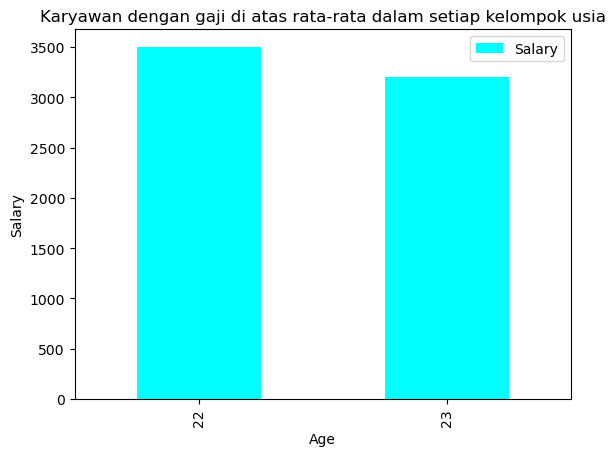

In [11]:
#Karyawan dengan gaji di atas rata-rata dalam setiap kelompok usia dan visualisasikan data dalam bentuk grafik batang atau pie chart.
AboveAVGSalary = spark.sql('''
WITH avg_salary_per_age_group AS (
    SELECT Age, AVG(Salary) AS avgSalary
    FROM employees
    GROUP BY Age
)
SELECT e.Name, e.Age, e.Salary, a.avgSalary
FROM employees e
JOIN avg_salary_per_age_group a ON e.Age = a.Age
WHERE e.Salary > a.avgSalary
ORDER BY e.Age
''').toPandas()

AboveAVGSalary.plot(x='Age', y='Salary', kind='bar', color='cyan')
plt.xlabel('Age')
plt.ylabel('Salary')
plt.title('Karyawan dengan gaji di atas rata-rata dalam setiap kelompok usia')
plt.show()


In [16]:
from pyspark.sql import SparkSession
import pandas as pd

# Inisialisasi SparkSession
spark = SparkSession.builder \
    .appName("DataAnalysis") \
    .getOrCreate()

data = pd.read_csv(r"C:\downloads\volley\clean_data.csv", encoding='ISO-8859-1')

spark_df = spark.createDataFrame(data)

spark_df.show(20)


+-----+--------------------+-------------+------+------+-----+-----+---------------+-------+
|index|                name|date_of_birth|height|weight|spike|block|position_number|country|
+-----+--------------------+-------------+------+------+-----+-----+---------------+-------+
|    0|  Angelina Lazarenko|   13/04/1998|   193|    80|  320|  305|              3|     23|
|    1|    Svetlana Serbina|   15/05/1996|   182|    71|  295|  284|              1|     23|
|    2|Ekaterina Shkurik...|   17/06/1996|   190|    72|  306|  296|              2|     23|
|    3|  Kristina Kurnosova|   17/06/1997|   176|    62|  288|  278|              6|     23|
|    4|  Ekaterina Novikova|   07/12/1996|   181|    70|  290|  275|              1|     23|
|    5|  Victoria Zhurbenko|   17/03/1996|   186|    67|  306|  297|              3|     23|
|    6| Angelina Sperskaite|   11/02/1997|   188|    72|  305|  295|              2|     23|
|    7|  Anastasiia Barchuk|   09/02/1996|   187|    78|  305|  297|  

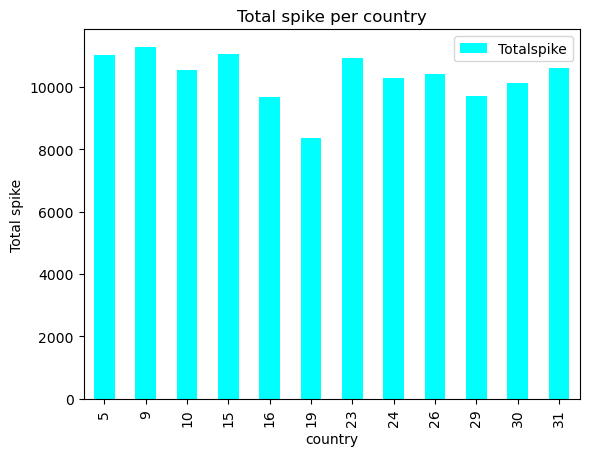

In [21]:
spark_df.createOrReplaceTempView("Topspike")

PerNegara = spark.sql('''
    SELECT country, SUM(spike) AS Totalspike, COUNT(name) AS Totalnames
    FROM Topspike
    GROUP BY country
    ORDER BY country
''').toPandas()

PerNegara.plot(x='country', y='Totalspike', kind='bar', color='cyan')
plt.xlabel('country')
plt.ylabel('Total spike')
plt.title('Total spike per country')
plt.show()


In [23]:
spark.sql('''
SELECT country, AVG(spike) AS avgGspike
FROM Topspike
GROUP BY country
''').show()

+-------+------------------+
|country|         avgGspike|
+-------+------------------+
|      9| 288.9230769230769|
|     10| 292.9166666666667|
|     23| 303.3333333333333|
|     16|293.27272727272725|
|     24| 285.3333333333333|
|     29|            269.75|
|     19|231.91666666666666|
|     31| 294.0833333333333|
|      5| 305.5833333333333|
|     26| 288.9166666666667|
|     15|            306.75|
|     30|             281.0|
+-------+------------------+



In [25]:
!pip install seaborn

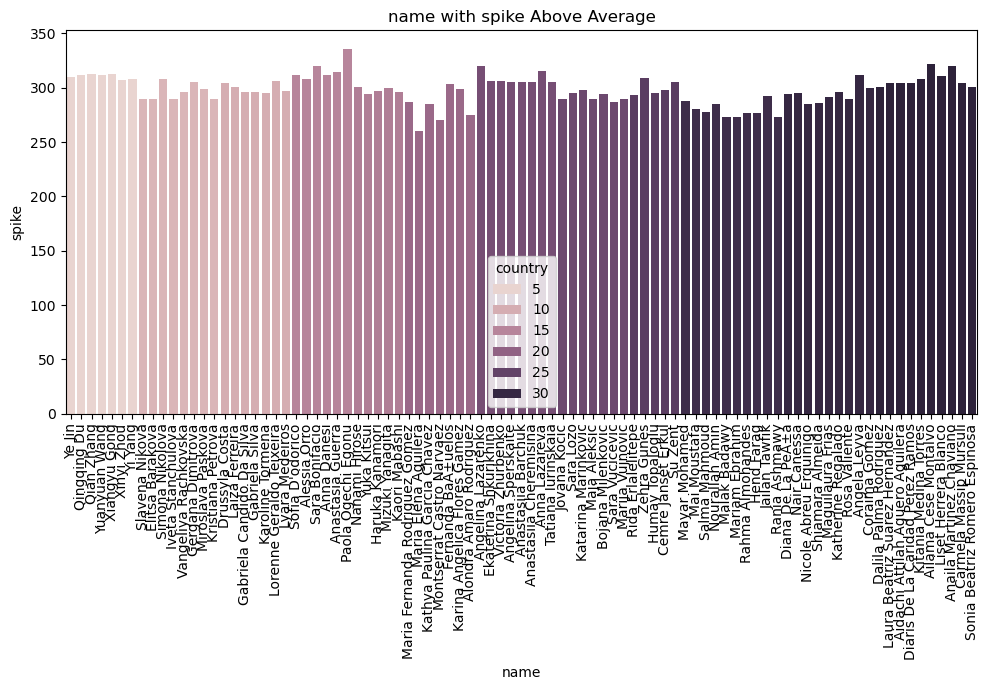

In [30]:
spikeAboveAVG = spark.sql('''
WITH avgspike AS (
    SELECT country, AVG(spike) AS avgspike
    FROM Topspike
    GROUP BY country
)
SELECT f.country, f.name, f.spike
FROM Topspike f
JOIN avgspike ags ON f.country = ags.country
WHERE f.spike > ags.avgspike
ORDER BY f.country
''').toPandas()

import seaborn as sns
plt.figure(figsize=(10, 7))

sns.barplot(x='name', y='spike', hue='country', data=spikeAboveAVG)
plt.xlabel('name')
plt.ylabel('spike')
plt.title('name with spike Above Average')
plt.xticks(rotation=90)
plt.legend(title='country')
plt.tight_layout()
plt.show(1)